### Load Data

In [1]:
from tensorflow.keras.callbacks import LambdaCallback
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.layers import LSTM
from tensorflow.keras.optimizers import RMSprop, Adam, Adadelta
from tensorflow.keras.utils import get_file
import tensorflow as tf
import numpy as np
import random
import sys
import io
import requests
import re
import pandas as pd
from itertools import chain
from tqdm import tqdm
import re
from uuid import uuid4
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# sess = tf.compat.v1.Session()

In [3]:
haikus = pd.read_parquet('./data/scraped/202003_scrape.parquet.gzip')

In [4]:
raw_text = haikus.text.unique().tolist()

In [5]:
len(raw_text)

2326

### Developing

In [6]:
text = [x.lower() for x in raw_text if isinstance(x, str)]
text = [re.sub('[^a-z\s/]', '', x) for x in text]
text = [re.sub('(?<=/)/', '', x) for x in text]

haiku_text = ' || '.join(text)

In [7]:
chars = list(chain.from_iterable(haiku_text))
chars = list(set(chars))

In [8]:
encode = {}
for i, unique_char in tqdm(enumerate(chars)):
    encode[unique_char] = i

decode = dict([(encode[key], key) for key in encode])

31it [00:00, 23364.50it/s]


In [9]:
# cut the text in semi-redundant sequences of maxlen characters
maxlen = 15
step = 3
sentences = []
next_chars = []
for i in range(0, len(haiku_text) - maxlen, step):
    sentences.append(haiku_text[i: i + maxlen])
    next_chars.append(haiku_text[i + maxlen])
print('nb sentences:', len(sentences))

nb sentences: 52073


In [10]:
print('Vectorization...')
x = np.zeros((len(sentences), maxlen, len(chars)), dtype=np.bool)
y = np.zeros((len(sentences), len(chars)), dtype=np.bool)
for i, sentence in enumerate(sentences):
    for t, char in enumerate(sentence):
        x[i, t, encode[char]] = 1
    y[i, encode[next_chars[i]]] = 1

Vectorization...


In [11]:
# build the model: a single LSTM
print('Build model...')
units = (128 * x for x in list(range(1, 3))[::-1])
model = Sequential()
model.add(LSTM(next(units), return_sequences=False, input_shape=(maxlen, len(chars))))
model.add(Dense(len(chars), activation='softmax'))

optimizer = RMSprop(lr=0.01)
model.compile(loss='categorical_crossentropy', optimizer=optimizer)

Build model...


In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 256)               294912    
_________________________________________________________________
dense (Dense)                (None, 31)                7967      
Total params: 302,879
Trainable params: 302,879
Non-trainable params: 0
_________________________________________________________________


In [13]:
# Ignore useless W0819 warnings generated by TensorFlow 2.0.  Hopefully can remove this ignore in the future.
# See https://github.com/tensorflow/tensorflow/issues/31308
import logging, os
logging.disable(logging.WARNING)
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

# Fit the model
history = model.fit(
    x,
    y,
    batch_size=128,
    epochs=6,
    validation_split=0.15,
    shuffle=True
)

Train on 44262 samples, validate on 7811 samples
Epoch 1/6
44262/44262 [==============================] - 18s 404us/sample - loss: 2.4056 - val_loss: 2.0858
Epoch 2/6
44262/44262 [==============================] - 17s 389us/sample - loss: 1.9263 - val_loss: 1.9037
Epoch 3/6
44262/44262 [==============================] - 16s 371us/sample - loss: 1.7555 - val_loss: 1.8356
Epoch 4/6
44262/44262 [==============================] - 17s 385us/sample - loss: 1.6158 - val_loss: 1.8218
Epoch 5/6
44262/44262 [==============================] - 17s 383us/sample - loss: 1.4827 - val_loss: 1.8703
Epoch 6/6
44262/44262 [==============================] - 17s 385us/sample - loss: 1.3641 - val_loss: 1.8892


In [16]:
tf.config.list_physical_devices('GPU')

[]

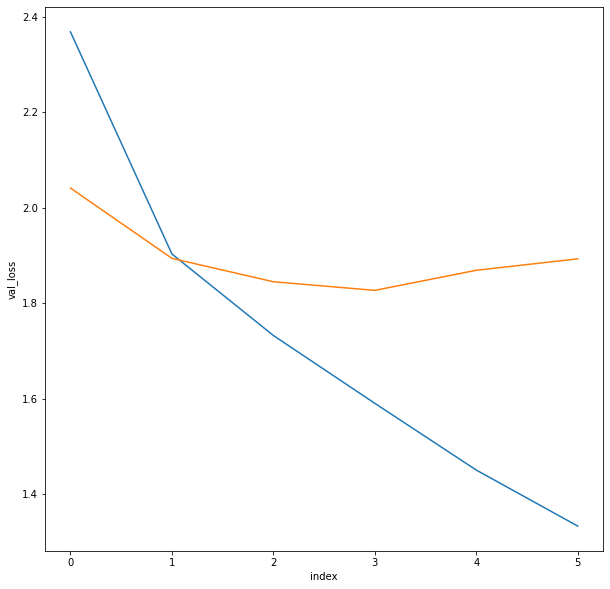

In [14]:
tmp = pd.DataFrame.from_dict(history.history).reset_index()

fig, ax = plt.subplots(figsize=(10, 10))

sns.lineplot(x='index', y='loss', data=tmp, ax=ax)
sns.lineplot(x='index', y='val_loss', data=tmp, ax=ax)
_ = plt.xticks(tmp.index)

In [15]:
def get_sample_output():
    random_start_point = np.random.randint(0, len(haiku_text) - maxlen - 1)
    sample_output = ''
    start_sample = haiku_text[random_start_point:random_start_point + maxlen]
    sample_output += start_sample
    assert len(sample_output) == 15
    for i in range(400):
        next_prediction = model.predict(sample_encoding(sample_output[-15:]))
        next_letter = sample_decode(next_prediction)
        sample_output += next_letter

    return sample_output

def sample_encoding(sample):
    encoded = np.zeros((1, len(sample), len(encode)), dtype=bool)
    for i, char in enumerate(sample):
        encoded[0, i, encode[char]] = 1
        
    return encoded

def sample_decode(prediction):
    preds = np.asarray(prediction).astype('float64')
    preds = np.log(preds)
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    
    letter = decode[np.argmax(preds)]
    return letter

In [16]:
test = get_sample_output()

In [17]:
print(test)

ivides us || univeryour and some the same || the stills misty and the same || the stills misty and the same || the stills misty and the same || the stills misty and the same || the stills misty and the same || the stills misty and the same || the stills misty and the same || the stills misty and the same || the stills misty and the same || the stills misty and the same || the stills misty and the same || the sti
